# Computational Modeling of Memory T-Cells in Response to Viral Infections

## Imports

Requirements:
* numpy: For useable arrays
* scipy: ```scipy.integrate.solve_ivp``` is our ODE solver of choice
* matplotlib: For making nice-looking graphs
* tqdm: Some ODEs take a minute to solve, so this gives us progress bars

In [1]:
import numpy as np
import scipy
import tqdm
from matplotlib import pyplot as plt

## Modeling T-Cell Response to Influenza in the Body

[Zarnitsyna et al. 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4861172/) describes a mathematical model for the spread and t-cell response of influenza with in humans. It uses a basic model based on the well known Susceptible-Infected-Recovered model for epidemiology, that has been applied to HIV and other viruses, as reviewed by [Graw et al. 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5072357/). This model has a strong focus on T-cell response, and chooses to leave many details of the total immune response out of the simulation. For example, B-cells and macrophage response are not simulated at all. Zarnitsyna describes the model in terms of 9 coupled ordinary differential equations (ODEs) which simulate the full course of an infection, and most importantly describes the population of memory and effector T-cells left behind.

In [2]:
class InfluenzaODEModel:
    DEFAULT_VECTOR = [4e8, 0, 1, 1e-6, 0, 1, 0, 0, 0]

    def __init__(self):
        # From: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5072357/
        # Production rate of healthy cells
        self._lambda = 100

        # From: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4861172/
        # Virus Infectivity
        self.beta = 3 * 10 ** -5
        # Viral Production
        self.p = 0.04
        # Rate of Virus Clearance
        self.c = 3
        # Infected Cell Lifespan
        self.delta = 1
        # Rate of killing of infected by T cells
        self.k_R = 0.007
        # Rate of conversion to refractory state
        self.k_M = 4
        # Max activation rate for innate immunity
        self.sigma_M = 1
        # Number of infected cells for half-max activation of innate immunity
        self.phi_M = 1
        # Decay rate for innate immunity
        self.d_M = 0.2
        # Rate of virus conversion to antigen
        self.gamma = 0.3
        # Rate of antigen decay
        self.d_A = 1.7
        # T cell proliferation rate
        self.rho = 2.15
        # Antigen for half-max proliferation
        self.phi = 50
        # Rate of migration to site of infection
        self.mu = 1.2
        # Rate of conversion from naive to memory
        self.r = 0.07
        # Rate of apoptosis for naive t cells
        self.alpha = 0.4
        # Death rate of effector t cells
        self.d_R = 0.1

    def ode(self, _, arr):
        T, I, V, M, A, T_p, T_E, T_M, T_R = arr
        return np.array([
            self._lambda + -self.beta * T * V - self.k_M * M * T,
            self.beta * T * V - self.k_R * T_R * I - self.delta * I,
            self.p * I - self.c * V,
            (self.sigma_M * I) / (self.phi_M + I)  * (1 - M) - self.d_M * M,
            self.gamma * V - self.d_A * A,
            -self.rho * T_p * (A / (self.phi + A)),
            self.rho * (T_p + T_E) * (A / (self.phi + A)) - (self.alpha + self.r) * T_E * (1 - (A / (self.phi + A))) - self.mu * T_E * M,
            self.r * T_E * (1 - A / (self.phi + A)),
            self.mu * T_E * M - self.d_R * T_R,
        ])

    def simulate(self, start_vector, time):
        return scipy.integrate.solve_ivp(self.ode, time, start_vector, method='LSODA')

    def graph(self, output, title, vars=None, *, outside_legend=False):
        all_vars = {
            'T': (0, 'Target Cells'),
            'I': (1, 'Infected Cells'),
            'V': (2, 'Viral Titer'),
            'M': (3, 'Innate Immunity'),
            'A': (4, 'Antigen'),
            'T_P': (5, 'Precursor T-Cells'),
            'T_E': (6, 'Naïve T-Cells'),
            'T_M': (7, 'Memory T-Cells'),
            'T_R': (8, 'Effector T-Cells')
        }

        if vars == None:
            vars = all_vars.keys()

        for var in vars:
            if var in all_vars:
                plt.plot(output.t, output.y[all_vars[var][0]], label=all_vars[var][1])

        plt.yscale('log')
        plt.ylim(1, 10**9)
        plt.ylabel('Count')
        plt.xlabel('Time (days)')
        plt.title(title, wrap=True)
        if outside_legend:
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        else:
            plt.legend()
        plt.show()

### Simulating a Primary Infection

Using the parameters outlined in Zarnitsyna yields the following response curves.

Graph 1: Infected Cell counts and viral load in the body
Graph 2: T-cell populations

Note: Graphs are both log-scaled on the y-axis

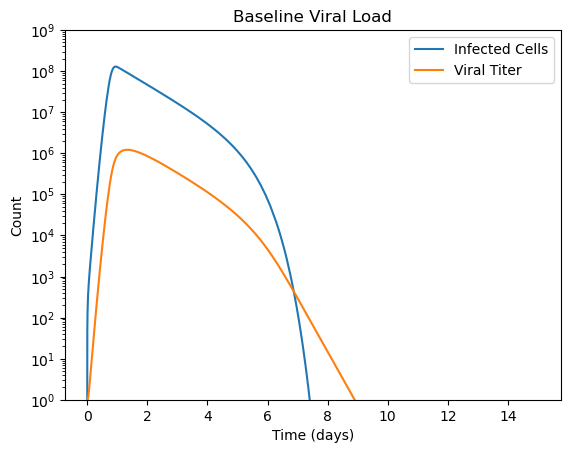

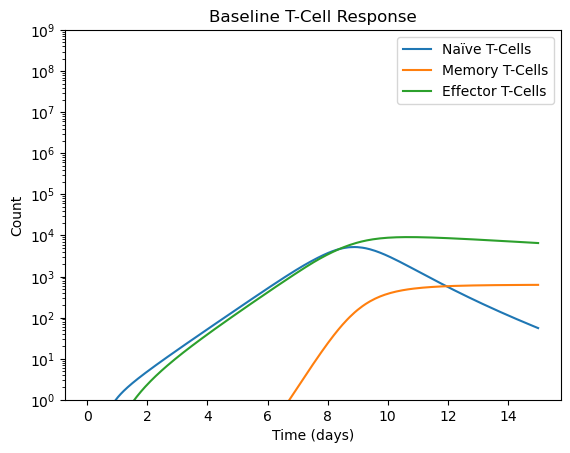

In [3]:
influenza = InfluenzaODEModel()
influenza_out = influenza.simulate(InfluenzaODEModel.DEFAULT_VECTOR, [0, 15])

influenza.graph(influenza_out, 'Baseline Viral Load', ['I', 'V'])
influenza.graph(influenza_out, 'Baseline T-Cell Response', ['T_E', 'T_M', 'T_R'])

Let's look at the T-Cell counts a year out of infection

Notice how the Effector T-cells exponentially decay and are gone by ~day 100, and the naïve t-cells are gone by day 25.

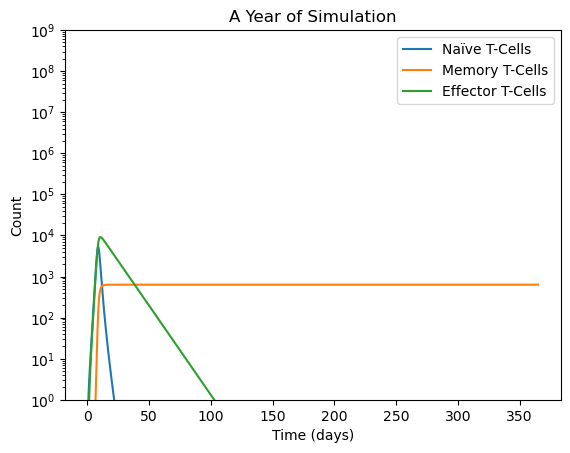

In [4]:
# Simulate memory cell population a year out from infection
one_year_later = influenza.simulate(InfluenzaODEModel.DEFAULT_VECTOR, [0, 365])

influenza.graph(one_year_later, 'A Year of Simulation', ['T_E', 'T_M', 'T_R'])

### Simulating a Secondary Infection

In a secondary infection, the memory T-cells are able to ramp up the immune response much quicker. In the model, this is accomplished by moving the memory T- cells to precursor T-cells.

Take a minute to compare this response to the primary response. Notice the differences in where the viral load hits the x-axis, and in the size of the t cell response.

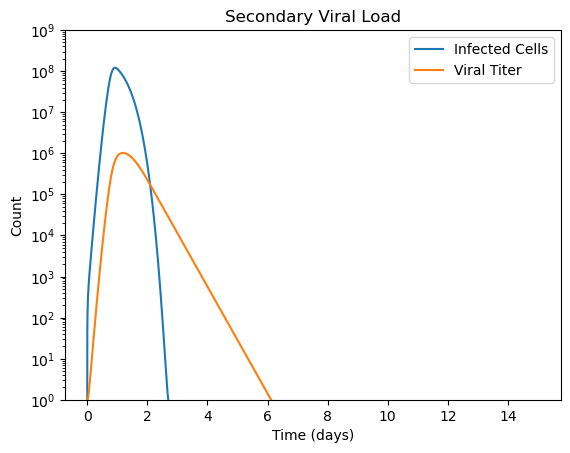

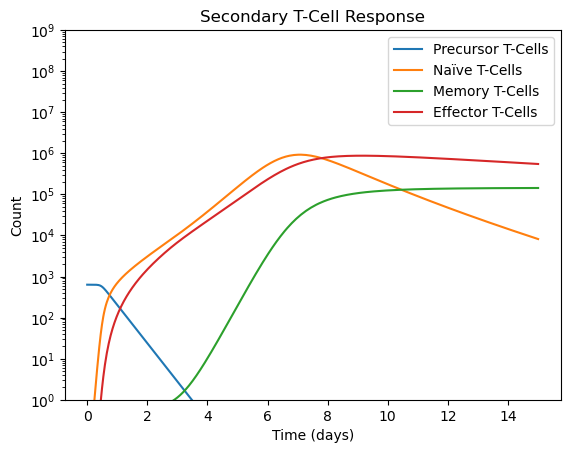

In [5]:
init_Tp = one_year_later.y[5,-1] + one_year_later.y[7,-1]
init_Tr = one_year_later.y[8,-1]

secondary_out = influenza.simulate([4 * 10 ** 8, 0, 1, 10 ** -6, 0, init_Tp, 0, 0, init_Tr], [0, 15])

influenza.graph(secondary_out, 'Secondary Viral Load', ['I', 'V'])
influenza.graph(secondary_out, 'Secondary T-Cell Response', ['T_P', 'T_E', 'T_M', 'T_R'])


A similar effect can be observed in a secondary infection after a vaccination. Vaccination is modeled by setting the viral infectivity (beta) to 0.

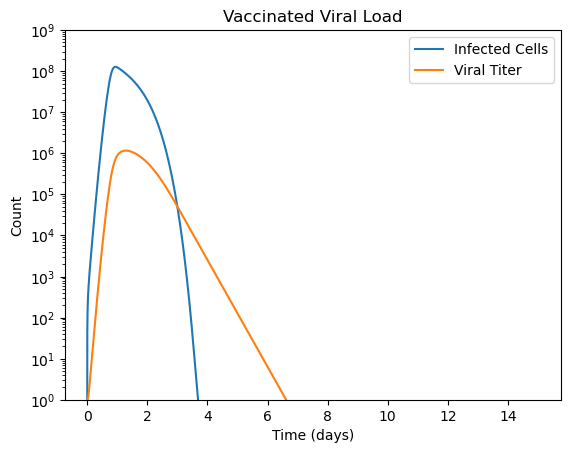

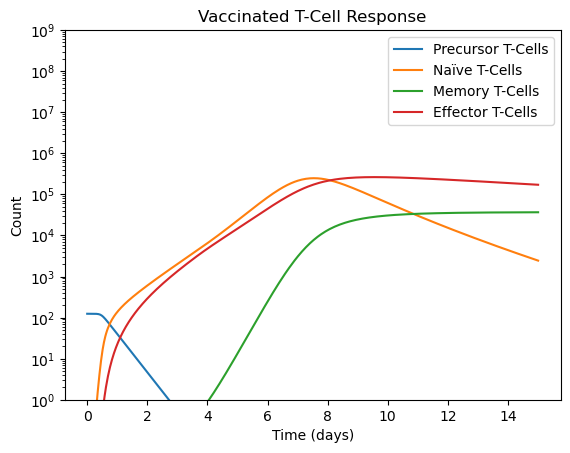

In [6]:
# Modeling a vaccine
vaccinated = InfluenzaODEModel()
vaccinated.beta = 0

vaccine_out = vaccinated.simulate([4e8, 0, 10 ** 5, 10 ** -6, 0, 1, 0, 0, 0], [0, 180])

# Simulate memory cell population a year out from infection
init_Tp = vaccine_out.y[5,-1] + vaccine_out.y[7,-1]
init_Tr = vaccine_out.y[8,-1]

vaccinated.beta = 3 * 10 ** -5

vaccine_out = vaccinated.simulate([4 * 10 ** 8, 0, 1, 10 ** -6, 0, init_Tp, 0, 0, init_Tr], [0, 15])

vaccinated.graph(vaccine_out, 'Vaccinated Viral Load', ['I', 'V'])
vaccinated.graph(vaccine_out, 'Vaccinated T-Cell Response', ['T_P', 'T_E', 'T_M', 'T_R'])


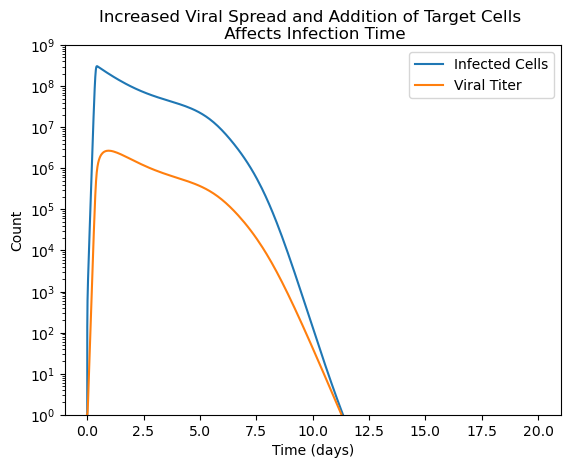

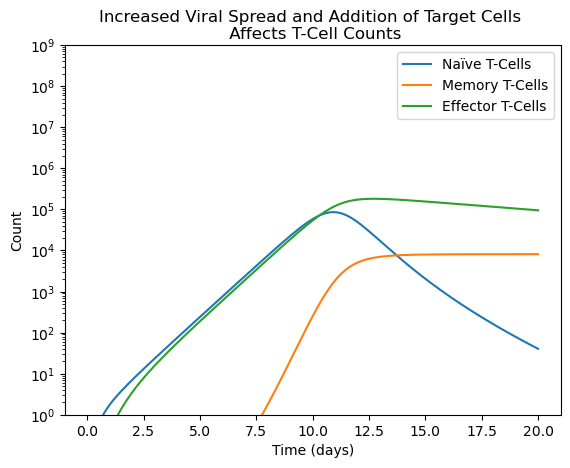

In [7]:
# Modeling viral spread

increased_spread_model = InfluenzaODEModel()
increased_spread_model._lambda = 4e7
increased_spread_model.beta = 1e-4
out = increased_spread_model.simulate(InfluenzaODEModel.DEFAULT_VECTOR, [0, 20])

increased_spread_model.graph(out, "Increased Viral Spread and Addition of Target Cells \n Affects Infection Time", ['I', 'V'])
increased_spread_model.graph(out, "Increased Viral Spread and Addition of Target Cells \n Affects T-Cell Counts", ['T_E', 'T_M', 'T_R'])

### Analyzing the Changing Dynamics of T-Cell Response as Time Increases


We will analyze it with two metrics:
1. Infection Clear Time: This is the amount of time it takes for the viral load to be cleared (in practice this means that it goes under 1)
2. Integral of Viral Titer: By taking a simple integral (trapezoidal approximation) of the viral load, we can measure the cumulative amount of virus in the body. This allows us to measure the amount of virus in the body in response to the variables.

In [8]:
# Finds the time when the viral titer goes below 0 after peaking
def infection_clear_time(t_arr, data_arr):
    V = data_arr[2]
    for i in range(1, len(V)):
        # Just a little below 1
        if V[i] < V[i-1] and V[i] < 0.9:
            return t_arr[i], i
    return t_arr[-1], -1



In [9]:
def integral_viral_load(t_arr, y_arr):
    V = y_arr[2]
    s = 0
    # Compute simple trapezoidal sum
    for i1, i2 in zip(range(len(t_arr)-1), range(1, len(t_arr))):
        width = t_arr[i2] - t_arr[i1]
        area = 1/2 * width * (V[i1] + V[i2])
        s += area

    return s

Simulation of the infections: We take samples each day after first exposure to the virus, and store the response, before analysis in the next two cells

In [10]:
# Simulating responses to infections starting immediately after the first infection is cleared
secondary_infection_model = InfluenzaODEModel()

start_vector = [4e8, 0, 1, 1e-6, 0, 1, 0, 0, 0]

times = np.arange(0, 365, 1)
infections = []
last_time = 0

for time in tqdm.tqdm(times):
    start_vector = secondary_infection_model.simulate(start_vector, [last_time, time]).y[:,-1]
    init_Tp = start_vector[5] + start_vector[7]
    init_Te = start_vector[6]
    init_Tr = start_vector[8]
    next_out = secondary_infection_model.simulate([4e8, 0, 1, 1e-6, 0, init_Tp, 0, 0, init_Tr], [0, 15])
    infections.append(next_out)
    last_time = time

_lambda = 100

100%|██████████| 365/365 [00:02<00:00, 164.37it/s]


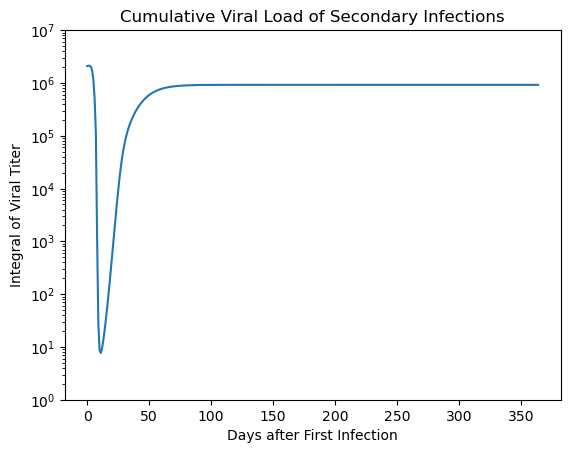

In [11]:
integral_viral_loads = []
for infection in infections:
    integral_viral_loads.append(integral_viral_load(infection.t, infection.y))

plt.plot(times, integral_viral_loads)
plt.yscale('log')
plt.ylabel('Integral of Viral Titer')
plt.xlabel('Days after First Infection')
plt.title('Cumulative Viral Load of Secondary Infections')
plt.ylim(1, 10**7)
plt.show()

Text(0.5, 1.0, 'Days to Clear Secondary Infection vs Primary Infection')

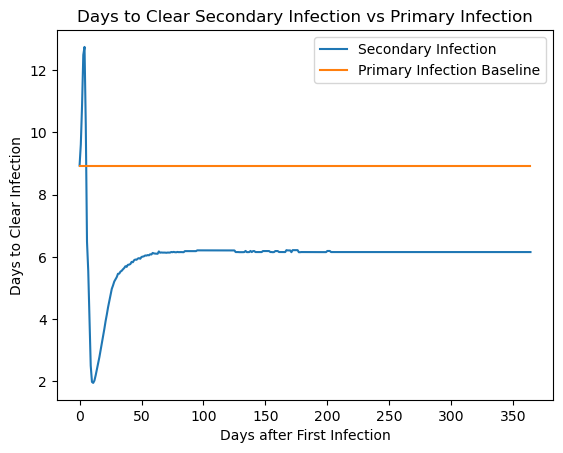

In [12]:
infection_clear_times = []
for infection in infections:
    infection_clear_times.append(infection_clear_time(infection.t, infection.y)[0])

plt.plot(times, infection_clear_times, label="Secondary Infection")
baseline = infection_clear_time(influenza_out.t, influenza_out.y)[0]
plt.plot(times, [baseline for _ in times], label="Primary Infection Baseline")

plt.xlabel('Days after First Infection')
plt.ylabel('Days to Clear Infection')
plt.legend()
plt.title('Days to Clear Secondary Infection vs Primary Infection')

## Modeling T-Cell Activation

Kinetic Proofreading (KPR) was first applied to T-Cell activation by [McKeithan 1995](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC41844/). In his article, McKeithan describes a system for t-cell activation based on a series of complexes becoming active. These complexes are representing a series of phosphorylations or another modification. The basic idea is that after a binding event with probability $k_{on}$, a series of N modifications will proceed at rate $k_p$ for each, with the final modification taking $k_N$ which is proceeds at a much lower rate. At each complex, there is also a chance, $k_{off}$ that the complexes will all revert and return to the start state, pre-binding. This allows small differences in affinities to manifest large differences down the line as with each complex, the difference grows exponentially. This makes the model a good description of antigen discrimination in TCRs as it can explain why small differences in the TCR result in wildly different bindings.

This model is a simplification on top of the true binding model. [Lever et al. 2016](https://pubmed.ncbi.nlm.nih.gov/27702900/) analyzes a more specified model, KPR with limited signaling and incoherent feedforward, and gives the ODEs that they used in their analysis at the end of their paper. The following system of ODEs are based on Lever and McKeithan's papers:

$$
\begin{align}
\frac{dR}{dt} &= -k_{on}RL + k_{off} (C_0 + C_1 + ... + C_{N-1}) + \phi k_{off} C_N \\
\frac{dL}{dt} &= -k_{on}RL + k_{off} (C_0 + C_1 + ... + C_{N-1}) + \phi k_{off} C_N \\
\frac{dC_0}{dt} &= k_{on}RL - (k_{off} + k_p)C_0 \\
\frac{dC_n}{dt} &= k_p C_{n-1} - (k_{off} + k_p)C_n \text{\ ,\ for\ } 1 \le n \le N-2 \\
\frac{dC_{N-1}}{dt} &= k_p C{N-2} - (k{off} + \phi k_p)C_{N-1}\\
\frac{dC_{N}}{dt} &= \phi k_p C_{N-1} - \phi k_{off} C_N \\
\end{align}
$$
where $N$ is the total number of complexes, $R$ is the amount of free MHC, $L$ is the amount of free tcr, and $C_0C_1...C_n$ denote the amount of bound MHC-TCR in each complex, and $\phi$ is a constant describing the increase in specificity for the final modification.

In [13]:
class KPRActivationODE:
    def __init__(self):
        self.k_on = 0.2
        self.k_off = 0.01
        self.k_p = 0.2
        self.phi = 0.5
        self.N = 6

    def ode(self, t, arr):
        free_ligand, free_tcr, *complexes = arr
        k_N, k_Noff = self.k_p * self.phi, self.k_off * self.phi

        dfree_ligand = -self.k_on * free_ligand * free_tcr + self.k_off * sum(complexes[:-1]) + k_Noff * complexes[-1]
        dfree_tcr = dfree_ligand
        dC_0 = self.k_on * free_ligand * free_tcr - (self.k_off + self.k_p) * complexes[0]
        dmiddle = []
        for c1, c2 in zip(complexes[:-3], complexes[1:-2]):
            dmiddle.append(self.k_p * c1 - (self.k_off + self.k_p) * c2)
        dC_Nminus1 = self.k_p * complexes[-3] - (self.k_off + k_N) * complexes[-2]
        dC_N = k_N * complexes[-2] - k_Noff * complexes[-1]

        return [dfree_ligand, dfree_tcr, dC_0, *dmiddle, dC_Nminus1, dC_N]

    def solve(self, inital_condition):
        return scipy.integrate.solve_ivp(self.ode, [0, 100], inital_condition, method='LSODA')

The following is a simple case of our KPR model. Notice, we don't reach 100% activation, and the curve is neither exponential nor sigmoidal.

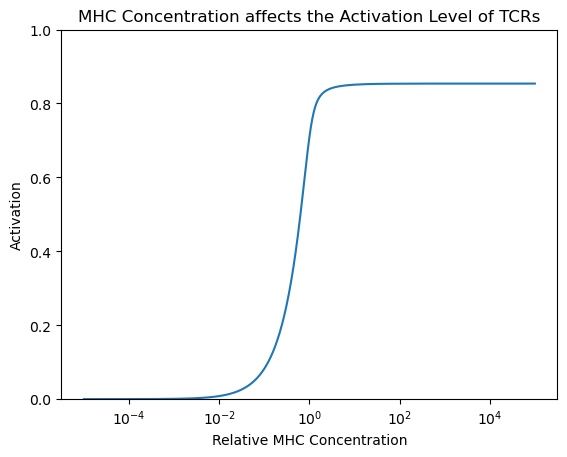

In [14]:
# Simple activation
model = KPRActivationODE()
X = np.logspace(-5, 5, num=1000, base=10)

y = []
for x in X:
    complexes = [0 for _ in range(model.N)]
    out = model.solve([x, 1, *complexes])
    activation = out.y[-1,-1]
    y.append(activation)

plt.plot(X, y)
plt.xscale('log')
plt.ylim(0, 1)
plt.xlabel('Relative MHC Concentration')
plt.ylabel('Activation')
plt.title('MHC Concentration affects the Activation Level of TCRs')
plt.show()

This model allows us to show the activation level's dependence on the MHC-TCR affinity as well.

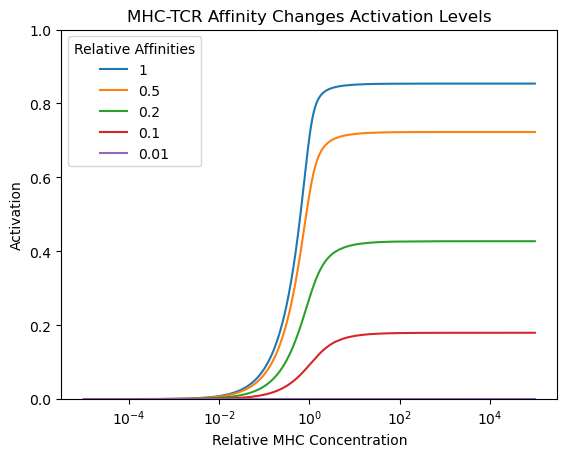

In [15]:
X = np.logspace(-5, 5, num=1000, base=10)

for k_off in [0.01, 0.02, 0.05, 0.1, 1]:
    koff_changed_model = KPRActivationODE()
    koff_changed_model.k_off = k_off
    y = []
    for x in X:
        complexes = [0 for _ in range(koff_changed_model.N)]
        out = koff_changed_model.solve([x, 1, *complexes])
        activation = out.y[-1,-1]
        y.append(activation)
    plt.plot(X, y, label=f"{0.01 / k_off:g}")

plt.xscale('log')
plt.legend(title='Relative Affinities')
plt.xlabel('Relative MHC Concentration')
plt.ylabel('Activation')
plt.title('MHC-TCR Affinity Changes Activation Levels')
plt.ylim(0, 1)
plt.show()